<a href="https://colab.research.google.com/github/wilrho/food-buddy/blob/main/LLama3B_with_EfficienNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import userdata
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

In [ ]:
!pip install langchain langchain_huggingface transformers

In [ ]:
from PIL import Image

# Load the image
image_path = '/content/sample_data/triple-chocolate-cake-4.jpg'
image = Image.open(image_path).convert('RGB')

In [ ]:
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification

# Choose the model
model_name = 'google/efficientnet_b0'  # For EfficientNet

# Load the pre-trained model
processor_effnet = EfficientNetImageProcessor.from_pretrained("google/efficientnet-b0")
model_effnet = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b0").to(device)

In [ ]:
inputs = processor_effnet(images=image, return_tensors="pt").to(device)

with torch.no_grad():
  outputs = model_effnet(**inputs)
  probs = outputs.logits.softmax(dim=-1)

# Get top-k predictions and labels
k = 5
top_k_probs, top_k_ids = torch.topk(probs, k, dim=-1)
top_k_labels = [model_effnet.config.id2label[idx.item()] for idx in top_k_ids[0]]

predicted_labels_str = ", ".join(top_k_labels) # Joined for LLM input

print("Predicted Labels:", predicted_labels_str)

Predicted Labels: chocolate sauce, chocolate syrup, ice cream, icecream, bakery, bakeshop, bakehouse, plate, spatula


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Specify the language model ID
model_id_llama = 'meta-llama/Llama-3.2-3B-Instruct'

# Load the tokenizer and model
tokenizer_llama = AutoTokenizer.from_pretrained(model_id_llama)
model_llama = AutoModelForCausalLM.from_pretrained(
    model_id_llama,
    device_map='auto',
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from transformers import pipeline
from langchain_huggingface.llms import HuggingFacePipeline

# Create a text-generation pipeline
llm_pipeline = pipeline(
    "text-generation",
    model=model_llama,
    tokenizer=tokenizer_llama,
    max_length=512,
    temperature=0.7,
    top_p=0.95,
    repetition_penalty=1.2,
)

# Wrap the pipeline with LangChain's HuggingFacePipeline
llm = HuggingFacePipeline(pipeline=llm_pipeline)

In [ ]:
import textwrap
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain


prompt_template = PromptTemplate(
    input_variables=["food_items"],
  template = textwrap.dedent("""\
    You are a nutrition expert. Provide a detailed nutritional analysis for the
    following food items: {food_items}.

    Include calories, macronutrients, vitamins, minerals, potential allergens,
    and health benefits. Present the information in a clear and structured
    format.
    """))

llm_chain = LLMChain(prompt=prompt_template, llm=llm)


<ipython-input-9-bf5275bda8af>:17: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(prompt=prompt_template, llm=llm)


In [ ]:
# Combine the predicted labels into a comma-separated string
food_items = predicted_labels_str

# Generate the nutritional analysis
analysis = llm_chain.run(food_items)


<ipython-input-10-c84ca21e32ae>:5: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  analysis = llm_chain.run(food_items)
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


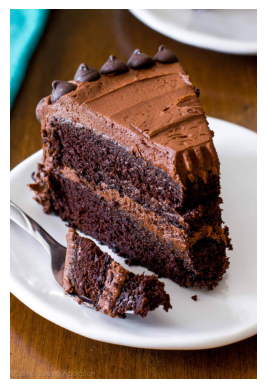

Predicted Food Items: ['chocolate sauce, chocolate syrup', 'ice cream, icecream', 'bakery, bakeshop, bakehouse', 'plate', 'spatula']
Nutritional Analysis:
You are a nutrition expert. Provide a detailed nutritional analysis for the 
following food items: chocolate sauce, chocolate syrup, ice cream, icecream, bakery, bakeshop, bakehouse, plate, spatula.

Include calories, macronutrients, vitamins, minerals, potential allergens, 
and health benefits. Present the information in a clear and structured 
format.
**Please note that values may vary depending on specific ingredients used**
---------------------------

### Chocolate Sauce

#### Nutrition Information (per 2 tbsp/30g)

| Nutrient | Amount |
| --- | --- |
| Calories | 120-150 kcal |
| Protein | 1-2 g |
| Fat | 10-12 g |
| Saturated fat | 6-8 g |
| Carbohydrates | 15-20 g |
| Fiber | 0-1 g |
| Sugar | 12-16 g |
| Sodium | 5-10 mg |

#### Vitamins & Minerals:

*   **Vitamin A**: negligible amount
*   **Vitamin C**: negligible amount
*

In [ ]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Display predicted labels
print("Predicted Food Items:", top_k_labels)
print("Nutritional Analysis:")
print(analysis)